### plot the z drift correlation for each frames, but only do the first 4000 frames 

In [1]:
import os
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import pickle
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("..")
from utils_image import compute_zpos_sp
from utils_analysis import plot_trajectory, getLinearSpeed, getAngularSpeed

In [2]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023/"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
RegTif_folder = os.path.join(processed_datafolder, 'reg_tif')

#load ops
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()

#load meanstacks.npy from datafolder, DP_exp
meanstacks = np.load(os.path.join(datafolder, "DP_exp", "meanstacks.npy"))

### get the correlation matrix for the first 4000 frames

In [3]:
binsize = 1
savefolder = os.path.join(datafolder, 'UnrotTiff/2D2P')
corrMatName = 'corrMatrix_binsize_' + str(binsize) + '.pkl'
#check if corrMatrix.pkl exists under savefolder
if os.path.isfile(os.path.join(savefolder, corrMatName)):
    with open(os.path.join(savefolder, corrMatName), 'rb') as f:
        all_corrMatrix = pickle.load(f)
else:
    #read all tif under the folder RegTif_folder 
    filenames = os.listdir(RegTif_folder)
    #sort the filenames by number
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #keep the first 4000 frames, which are the first 8 files
    filenames = filenames[:8]
    # Load the registered tiff image
    all_corrMatrix = {}
    for filename in filenames:
        print('processing: ' + filename)
        regFrames = []
        with tf.TiffFile(os.path.join(RegTif_folder, filename)) as tif:
            for page in tif.pages:
                image = page.asarray()
                #transpose the image because the image is rotated after suite2p processing
                regFrames.append(image.T)
        regFrames = np.array(regFrames)
        
        #bin every binsize frames and take the mean
        bin_regFrames = regFrames.reshape(-1, binsize, regFrames.shape[1], regFrames.shape[2]).mean(axis=1)
                
        #perform phase correlation
        _, _, corrMatrix = compute_zpos_sp(meanstacks, bin_regFrames, ops)
        
        #append the corrMatrix to all_corrMatrix
        all_corrMatrix[filename] = corrMatrix 
    
    #save the all_corrMatrix to pickle file
    with open(os.path.join(savefolder, corrMatName), 'wb') as f:
        pickle.dump(all_corrMatrix, f)

#for all elements in all_corrMatrix, concatenate them by the first dimension
corrMatrix = np.concatenate(list(all_corrMatrix.values()), axis=1)
nplanes, nframes = corrMatrix.shape

### Load the trajectory and selected the trajectory only correpspoding to the first 4000 frames

In [4]:
filenamelist = ["00004", "00005", "00006", "00007", "00008", "00009", "00010", "00012", "00014", "00016", "00017", "00018"]

#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX = trajectory[0]
    allZ = trajectory[1]
    allTime = trajectory[2]
    allTheta = trajectory[3]
else:
    allX, allZ, allTime, allTheta, fig = plot_trajectory(datafolder, filenamelist)
    
#change allX and allZ from dictionary to np.array
Traj_x = np.concatenate(list(allX.values()))
Traj_z = np.concatenate(list(allZ.values()))
Theta = np.concatenate(list(allTheta.values()))
#change degree to radian]
Theta = Theta/180*np.pi

#normalize x and z to [0,1]
Traj_x = (Traj_x-np.min(Traj_x))/(np.max(Traj_x)-np.min(Traj_x))
Traj_z = (Traj_z-np.min(Traj_z))/(np.max(Traj_z)-np.min(Traj_z))


#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime)):
    #chnage allTime[i] to np.array
    allTime[i] = np.array(allTime[i])
    if i == 0:
        timestamps = allTime[i]
    else:
        timestamps = np.concatenate((timestamps, allTime[i]+timestamps[-1]+0.033))

#get the linear speed
linearspeed = getLinearSpeed(Traj_x, Traj_z, timestamps, boxcar_size=0)
#cut the speed to the same length
linearspeed = linearspeed[:nframes*binsize]
#every binsize data points, take the mean
linearspeed = linearspeed.reshape(-1, binsize).mean(axis=1)
            
#get the angular speed
angularspeed = getAngularSpeed(Theta, timestamps)  
#cut the angular_speed to the same length 
angularspeed = angularspeed[:nframes*binsize]
#every binsize data points, take the mean
angularspeed = angularspeed.reshape(-1, binsize).mean(axis=1)     


### plot the z drift correlation together with linear speed and angular speed

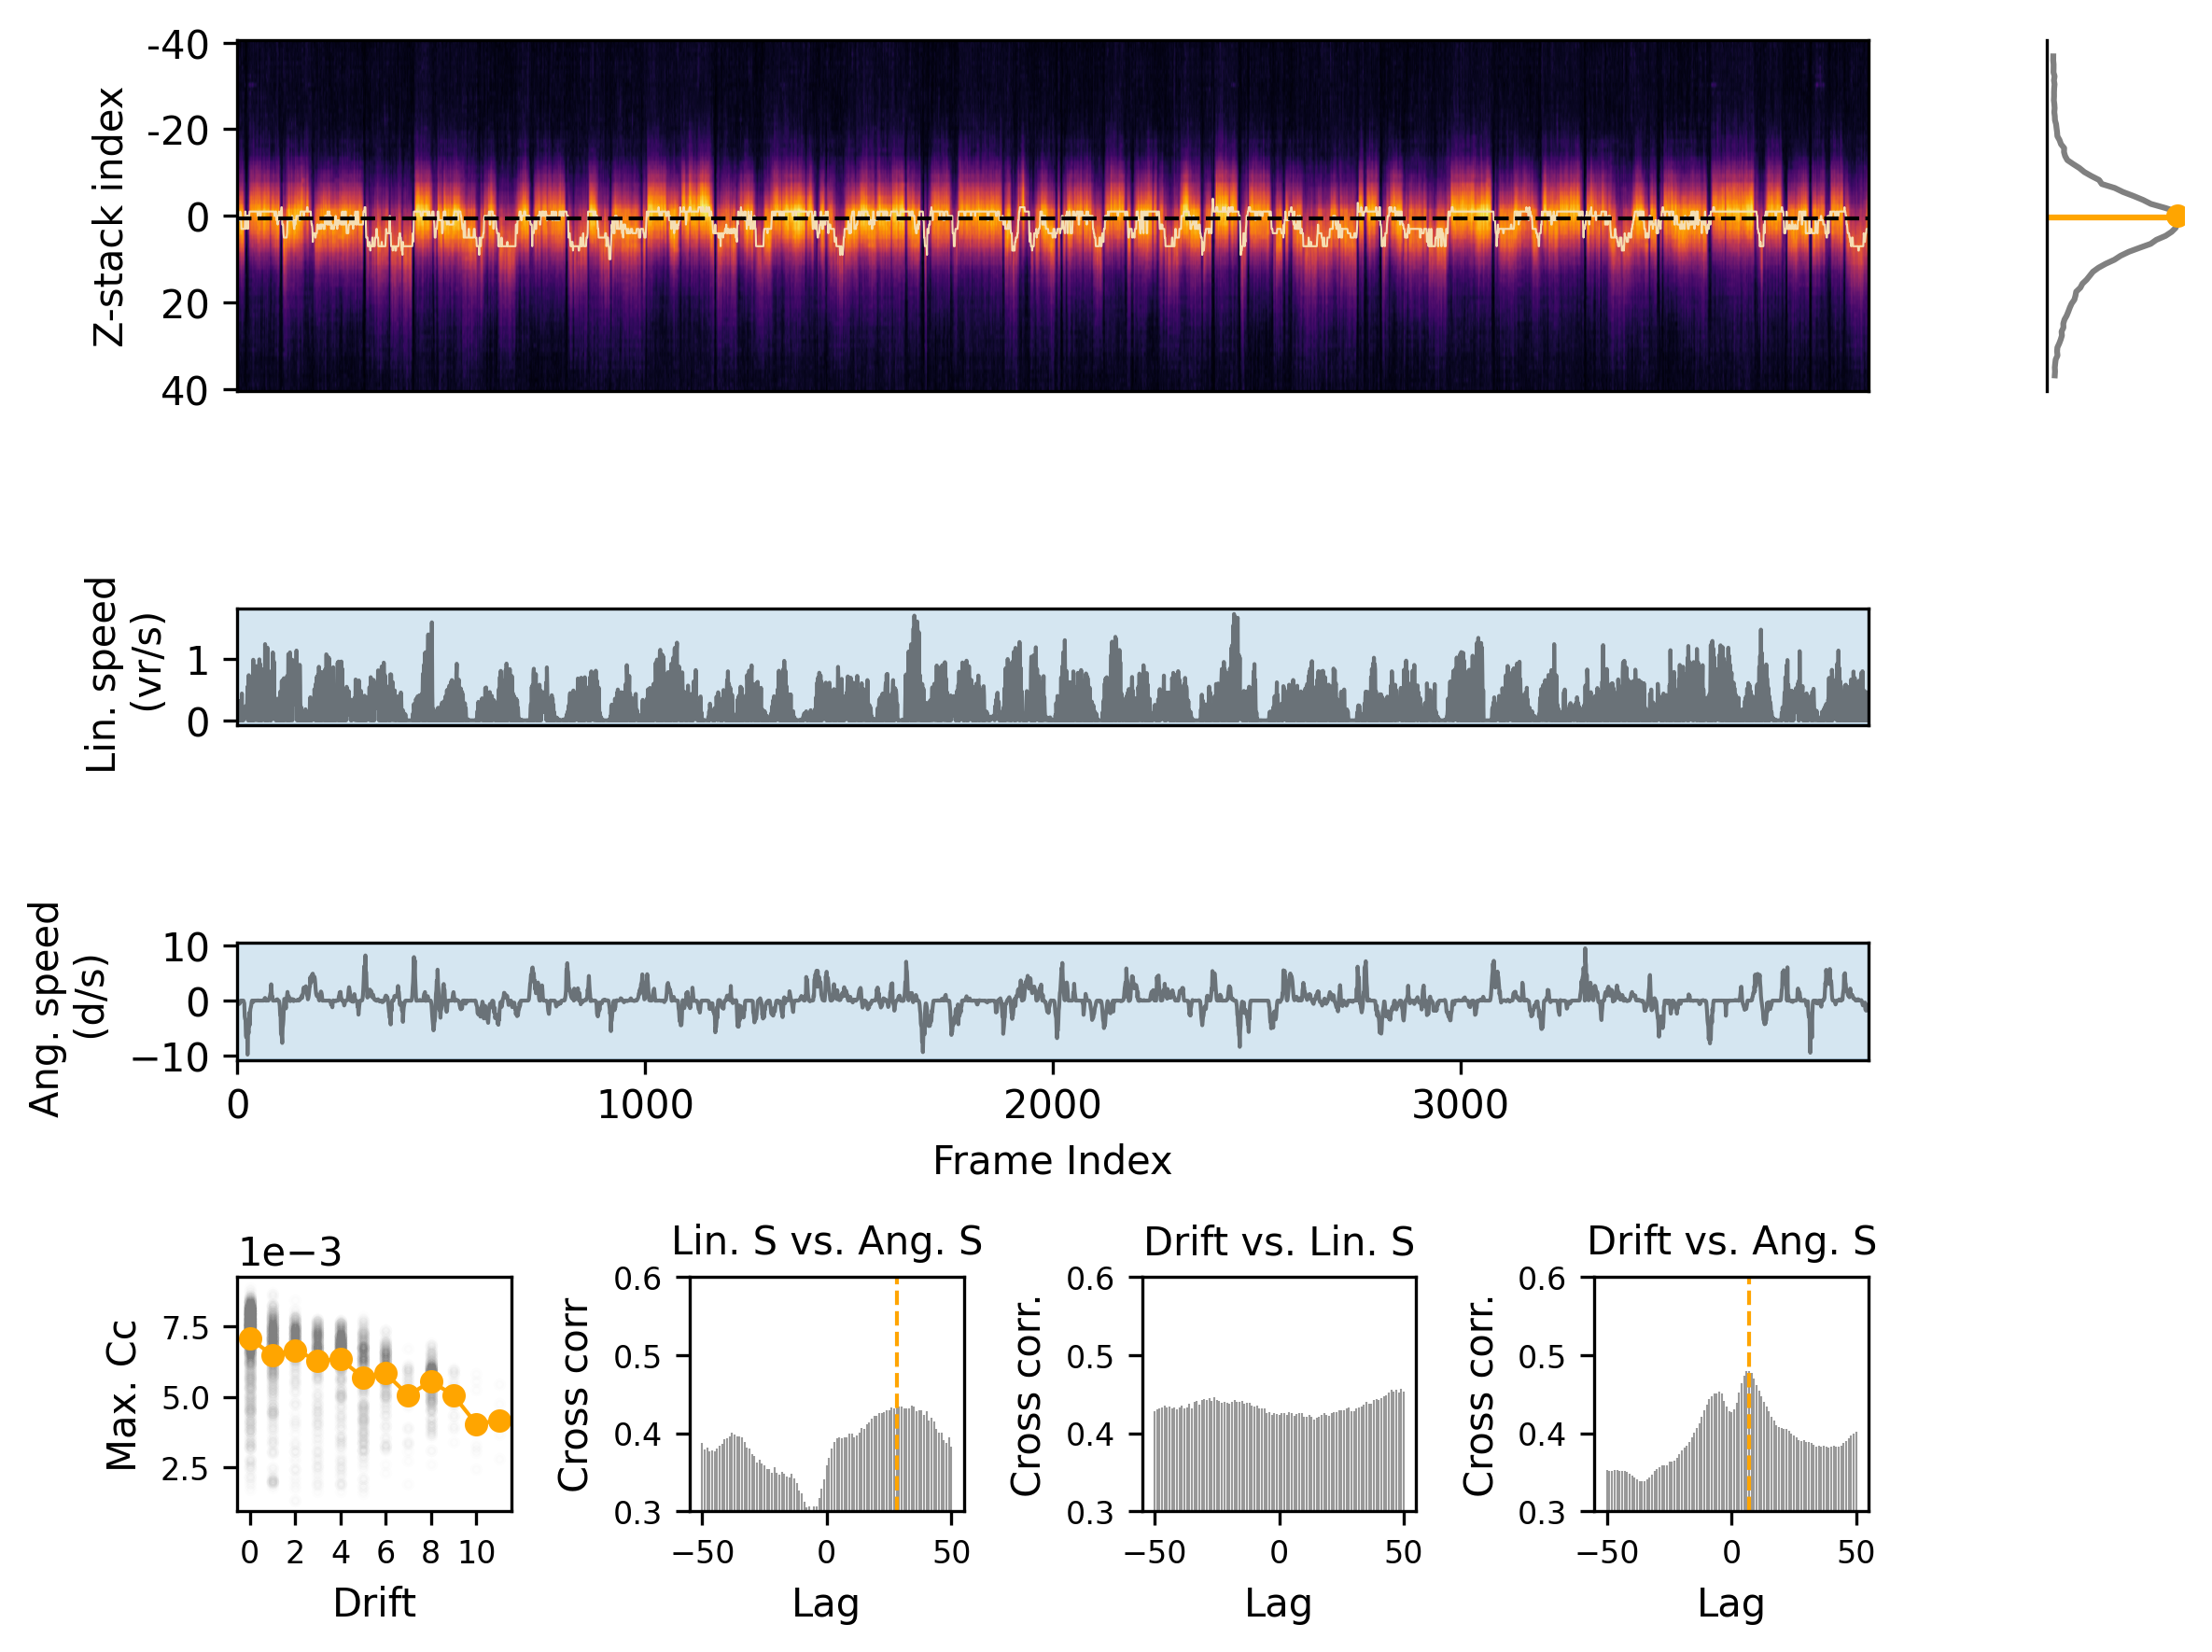

In [8]:
#two subplots using gridspec, one for correlation matrix and one for speed
fig = plt.figure(figsize=(8, 6),dpi=300)

labelsize = 10
ticksize = 8

gs = GridSpec(4, 5, height_ratios=[3, 1, 1, 2], width_ratios=[1, 1, 1, 1, 0.5])

driftcenter = int(nplanes/2)

###########################ax00###########################
ax00 = fig.add_subplot(gs[0, :4])
ax00.imshow(corrMatrix, aspect='auto',cmap='inferno')


#get the index of maximum value at each cloumn in corrMatrix
maxIndex = np.argmax(corrMatrix, axis=0)
#get teh drift value by subtracting the driftcenter and taking the absolute value
drift =  np.abs(maxIndex - driftcenter)
#add plot at the maximum value in each column to the plot
ax00.plot(np.arange(0, nframes), maxIndex, color='wheat', linestyle='-', linewidth=0.5)

#add a line to separate the two blocks
ax00.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=1)


#set xlim
ax00.set_xlim([0, nframes])
# #set x ticks every 1000 frames
# xticks = np.arange(0, nframes, 1000)
# ax1.set_xticks(xticks)
# ax1.set_xticklabels(xticks*binsize)
#set xticks off
ax00.set_xticks([])
ax00.set_ylabel('Z-stack index', fontsize=labelsize)
#recenter the y label with zero representing the middle stack
ax00.set_yticks(np.arange(0, nplanes, 20))    
ax00.set_yticklabels(np.arange(0, nplanes, 20)-driftcenter)


###########################ax01###########################
#do the second plot
ax03 = fig.add_subplot(gs[0, 4])
#sum the correlation matrix along the frame axis
sumCorrMatrix = np.sum(corrMatrix, axis=1)
#plot with a grey line
ax03.plot(sumCorrMatrix, np.arange(0, nplanes), color='grey')

#add a red line to separate the two blocks
ax03.axhline(y=nplanes/2, color='orange', linestyle='-')
#find the peak of the sumCorrMatrix and plot it with a red dot
maxIndex = np.argmax(sumCorrMatrix)
ax03.plot(sumCorrMatrix[maxIndex], maxIndex, color='orange', marker='o', markersize=5)

#flip y axis
ax03.set_ylim(ax03.get_ylim()[::-1])
#set y ticks off
ax03.set_yticks([])
#set xtick off
ax03.set_xticks([])
#set top right bottom axis off
ax03.spines['top'].set_visible(False)
ax03.spines['right'].set_visible(False)
ax03.spines['bottom'].set_visible(False)

############################ax11###########################
ax11 = fig.add_subplot(gs[1, :4])
#choose colormap when plot, equally sampled from tab20c accodring to the number of sessions
colors = plt.cm.tab20c(np.linspace(0, 1, len(allX)))

ax11.plot(linearspeed, linewidth=1, color='k', alpha=0.5)
#add shaeded area with different colors to mark different sessions
split_ind = np.cumsum([len(allTime[i])/binsize for i in range(len(allTime))])
#change each element in split_ind to int
split_ind = split_ind.astype(int)
#add 0 at the beginning 
split_ind = np.concatenate(([0], split_ind))
for i in range(len(allTime)):
    ax11.axvspan(split_ind[i], split_ind[i+1], alpha=0.2, color=colors[i])

#set x ticks every 1000 frames
xticks = np.arange(0, nframes, 1000)
#set xticks off
ax11.set_xticks([])
#set xlim
ax11.set_xlim([0, nframes])
#xlabel and ylabel and rotation for 90 degree
ax11.set_ylabel('Lin. speed \n (vr/s)', fontsize=labelsize)

############################ax21###########################
ax21 = fig.add_subplot(gs[2, :4])
#choose colormap when plot, equally sampled from tab20c accodring to the number of sessions
colors = plt.cm.tab20c(np.linspace(0, 1, len(allX)))
ax21.plot(angularspeed, linewidth=1, color='k', alpha=0.5)
#add shaeded area with different colors to mark different sessions
split_ind = np.cumsum([len(allTime[i])/binsize for i in range(len(allTime))])
#change each element in split_ind to int
split_ind = split_ind.astype(int)
#add 0 at the beginning 
split_ind = np.concatenate(([0], split_ind))
for i in range(len(allTime)):
    ax21.axvspan(split_ind[i], split_ind[i+1], alpha=0.2, color=colors[i])

#set x ticks every 1000 frames
xticks = np.arange(0, nframes, 1000)
ax21.set_xticks(xticks)
ax21.set_xticklabels(xticks*binsize)
#set xlim
ax21.set_xlim([0, nframes])
#xlabel and ylabel  
ax21.set_xlabel('Frame Index', fontsize=labelsize)
#center align the y label
ax21.set_ylabel('Ang. speed \n (d/s)', fontsize=labelsize)

############################ax30###########################
ax30 = fig.add_subplot(gs[3, 0])
#get the index of maximum value at each cloumn in corrMatrix
maxIndex = np.argmax(corrMatrix, axis=0)
#get teh drift value by subtracting the driftcenter and taking the absolute value
drift =  np.abs(maxIndex - driftcenter+1)
#get the maximum value at each column
maxValue = np.max(corrMatrix, axis=0)

#plot the drift vs. the maximum value
ax30.scatter(drift, maxValue, color='grey', s=5, alpha=0.01)
#get mean value of the maximum value at each drift value and plot it 
#first, find the unique values of drift
unique_drift = np.unique(drift)
#then, find the mean of maxValue for each unique value of drift
mean_maxValue = np.array([np.mean(maxValue[drift==unique_drift[i]]) for i in range(len(unique_drift))])
#plot the mean_maxValue with a line
ax30.plot(unique_drift, mean_maxValue, color='orange', linewidth=1, marker='o', markersize=5)

#label
ax30.set_xlabel('Drift', fontsize=labelsize)
ax30.set_ylabel('Max. Cc', fontsize=labelsize)
#add xticks evry 2
ax30.set_xticks(unique_drift[::2])
#set y ticks using scientific notation
ax30.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#set tick size
ax30.tick_params(labelsize=ticksize)

############################ax31###########################
ax31 = fig.add_subplot(gs[3, 1])
lag = 50
labelsize = 10
ticksize = 8
#third, perform cross correlation with lag = 10 frames, and plot the result, between linearspeed and np.abs(angularspeed)
ax31.xcorr(linearspeed, np.abs(angularspeed), usevlines=True, maxlags=lag, normed=True, lw=0.5, color='grey', alpha=0.8)

#do coross correlation between drift and angular speed using numpy
cc = np.correlate(linearspeed, np.abs(angularspeed), mode='full')
#find the shift of maximum correlation
shift = np.argmax(cc)-len(drift)+1
#mark the shift with a vertical orange line
ax31.axvline(x=shift, color='orange', linestyle='--', linewidth=1)

ax31.set_xlabel('Lag', fontsize=labelsize)
ax31.set_ylabel('Cross corr', fontsize=labelsize)
#set y lim from 0 to 0.5
ax31.set_ylim([0.3, 0.6])
#set tick size
ax31.tick_params(labelsize=ticksize)
#title
ax31.set_title('Lin. S vs. Ang. S', fontsize=labelsize)

############################ax32###########################
ax32 = fig.add_subplot(gs[3, 2])
lag = 50
#second, perform cross correlation between linearspeed, drift, and plot the result with lag = 10 frames, and plot the result
ax32.xcorr(drift, linearspeed, usevlines=True, maxlags=lag, normed=True, lw=0.5, color='grey', alpha=0.8)
ax32.set_xlabel('Lag', fontsize=labelsize)
ax32.set_ylabel('Cross corr.', fontsize=labelsize)
#set y lim from 0 to 0.5
ax32.set_ylim([0.3, 0.6])
#set tick size
ax32.tick_params(labelsize=ticksize)
#set title
ax32.set_title('Drift vs. Lin. S', fontsize=labelsize)

############################ax33###########################
ax33 = fig.add_subplot(gs[3, 3])
#second, perform cross correlation with lag = 10 frames, and plot the result
ax33.xcorr(drift, np.abs(angularspeed), usevlines=True, maxlags=lag, normed=True, lw=0.5, color='grey', alpha=0.8)

#do coross correlation between drift and angular speed using numpy
cc = np.correlate(drift, np.abs(angularspeed), mode='full')
#find the shift of maximum correlation
shift = np.argmax(cc)-len(drift)+1
#mark the shift with a vertical orange line
ax33.axvline(x=shift, color='orange', linestyle='--', linewidth=1)

ax33.set_xlabel('Lag', fontsize=labelsize)
ax33.set_ylabel('Cross corr.', fontsize=labelsize)
#set y lim from 0 to 0.5
ax33.set_ylim([0.3, 0.6])
#set tick size
ax33.tick_params(labelsize=ticksize)
#title
ax33.set_title('Drift vs. Ang. S', fontsize=labelsize)

#reduce the column space only between the last column and the second last column
    
#tight_layout
plt.tight_layout()

#save figure as pdf
savefolder = os.path.join(datafolder, 'UnrotTiff/2D2P')
plt.savefig(os.path.join(savefolder, 'ZdriftCorrelation.pdf'), dpi=300)